In [1]:
""" revenue in millions """

' revenue in millions '

In [2]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
print(tf.__version__)

2.8.0


In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from keras.models import Sequential

In [5]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 9,
        "text.usetex": True,
        "font.family": "serif",
        "figure.figsize": (4, 3),
        "legend.fontsize": 'medium',
        })

In [6]:
%matplotlib widget

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
# get path of the directory in which your script is running
ref_path = os.path.abspath('')
ref_path = pathlib.Path(ref_path).resolve().parents[1]
ref_path

PosixPath('/home/yuchen/work_leslie/KTP_Croud')

In [9]:
os.chdir(ref_path)


In [10]:
os.getcwd()

'/home/yuchen/work_leslie/KTP_Croud'

In [11]:
from src.modelling.modules import plot_history_info
from src.modelling.models import build_and_compile_model, create_aleatoric_model

# import the data

In [12]:
# import data
dataset = pd.read_csv('data/raw/weekly_media_sample.csv', header=0,)
dataset.drop(columns='X', inplace=True)

In [13]:
time_axis = dataset.pop('DATE')

In [14]:
# process data

# revenue in millions 
dataset['revenue'] = dataset['revenue'] / 1000000

In [15]:
dataset.head()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,2.754372,167687.6,95463.66667,228213.98740,8125009,19401.65
1,2.584277,214600.9,0.00000,34258.57351,7901549,14791.00
2,2.547387,0.0,3404.00000,127691.26130,8300197,14544.00
3,2.875220,625877.3,132600.00000,84014.72031,8122883,2800.00
4,2.215953,0.0,0.00000,20687.47816,7105985,15478.00


In [16]:
dataset.shape

(208, 6)

In [17]:
''' specify the split '''

train_val_split = 200

In [18]:
# double check

dataset.iloc[train_val_split-1]

revenue             2.575148e+00
media1_S            0.000000e+00
media2_S            1.095323e+05
media3_S            3.992652e+04
competitor_sales    8.116568e+06
newsletter          7.041700e+04
Name: 199, dtype: float64

In [19]:
train_dataset = dataset[:train_val_split]
test_dataset = dataset[train_val_split:]

In [20]:
train_dataset.shape

(200, 6)

In [21]:
test_dataset

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
200,2.510952,208627.1,0.00000,0.0000,7702931,50905.00
201,2.275620,0.0,147067.00000,0.0000,7060116,79428.00
202,2.505162,144479.6,0.00000,415793.8103,7603752,58284.00
203,2.456240,0.0,153723.66670,0.0000,7612762,28157.00
204,2.182825,154917.6,0.00000,133624.5755,6701667,10644.00
205,2.377707,21982.5,17476.00000,0.0000,7688920,9597.00
206,2.732825,22453.0,24051.33333,0.0000,8815710,90189.00
207,2.767788,0.0,0.00000,366190.7594,9067759,19401.65


In [22]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('revenue')
test_labels = test_features.pop('revenue')

In [23]:
train_features.shape

(200, 5)

In [24]:
train_features.head()

,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,167687.6,95463.66667,228213.98740,8125009,19401.65
1,214600.9,0.00000,34258.57351,7901549,14791.00
2,0.0,3404.00000,127691.26130,8300197,14544.00
3,625877.3,132600.00000,84014.72031,8122883,2800.00
4,0.0,0.00000,20687.47816,7105985,15478.00


In [25]:
train_labels.shape

(200,)

In [26]:
# change to numpy arrays

train_features = train_features.values
test_features = test_features.values

train_labels = train_labels.values
test_labels = test_labels.values

In [27]:
test_labels.shape

(8,)

In [28]:
# normalization

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 113018.484   27371.74    62366.473 5448277.5     21548.955]]


In [29]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 167687.6    95463.67  228213.99 8125009.     19401.65]]

Normalized: [[ 0.25  1.43  1.84  1.3  -0.12]]


# Modelling

### a deterministic DNN model as `reference`

In [ ]:
# # without normalization

# dnn_model = keras.Sequential([
#   layers.Dense(128, activation='relu', input_shape=(5,)),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(1)
# ])

# dnn_model.compile(loss='mae',
#             optimizer=tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanAbsolutePercentageError(
#     name='mean_absolute_percentage_error', dtype=None
# )])

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1,
    epochs=100)

In [ ]:
plot_history_info(history)

### an aleatoric DNN model that computes `data noise`

In [ ]:
aleatoric_model = create_aleatoric_model(
                        input_shape = 5, 
                        norm = normalizer)

In [ ]:
history_aleatoric = aleatoric_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

In [ ]:
plot_history_info(history_aleatoric)

In [ ]:
aleatoric_model.evaluate(test_features, test_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

# plot the train and val [revenue] series 
ax.plot(dataset.revenue)

# boundry between train and val
ax.axvline(x=200, ymin=0, ymax=1, color='r', linestyle='--')\

val_x_axis = np.arange(200, 208)

# add the predictions then 
ax.scatter(val_x_axis, test_labels, color='r', marker='o')

# mean prediction
ax.plot(val_x_axis, y_hat, color='black')
ax.plot(val_x_axis, y_hat_m2sd, color='green', alpha=0.8)
ax.plot(val_x_axis, y_hat_p2sd, color='green', alpha=0.8)

In [ ]:
# model prediction with aleatoric model
y_model = aleatoric_model(test_features)

y_hat = y_model.mean()
y_hat_m2sd = y_hat - 2 * y_model.stddev()
y_hat_p2sd = y_hat + 2 * y_model.stddev()

In [ ]:
# val range only

fig, ax = plt.subplots()

val_x_axis = np.arange(0, 8)

# gt
ax.scatter(val_x_axis, test_labels, marker='o', alpha=0.4, label='gt')


# mean prediction
ax.plot(val_x_axis, y_hat, color='blue')
ax.plot(val_x_axis, y_hat_m2sd, 'g--', label='95 interval')
ax.plot(val_x_axis, y_hat_p2sd, 'g--')
ax.legend()

ax.set_ylabel('Revenue')        
ax.set_xlabel('validation')


### Construct a BNN model

In [ ]:
# # Define the prior weight distribution -- all N(0, 1) -- and not trainable

# def prior(kernel_size, bias_size, dtype=None):
#     # number of parameters
#     n = kernel_size + bias_size
#     prior_model = Sequential([
#         tfpl.DistributionLambda(
#         lambda t : tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
#                                   reinterpreted_batch_ndims=1))
#     ])
#     return prior_model


# # Define variational posterior weight distribution -- multivariate Gaussian

# def posterior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size 
#     posterior_model = Sequential([
#         tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
#         tfpl.IndependentNormal(n, convert_to_tensor_fn=tfd.Distribution.sample)
#     ])
#     return posterior_model

# # define the "negative log likelihood" as loss function
# def nll(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

In [ ]:
# # Create probabilistic regression with one hidden layer, weight uncertainty

# model = Sequential([
#     normalizer,
#     tfpl.DenseVariational(
#         units= 16,
#         input_shape=(5,),
#         make_prior_fn=prior,
#         make_posterior_fn=posterior,
#         kl_weight=1/N,
#         activation='relu'),   
#     tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
#                           make_prior_fn=prior,
#                           make_posterior_fn=posterior,
#                           kl_weight=1/N),
#     tfpl.IndependentNormal(1),
# ])


In [ ]:
# ''' compile and train '''

# # model.compile(
# #     loss=nll, 
# #     optimizer=tf.keras.optimizers.Adam(),
# #     metrics=["mae"])

# model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(), metrics=['mae'])

# # Train the model

# BNN_history = model.fit(
#     train_features,
#     train_labels,
#     validation_data = (test_features, test_labels),
#     batch_size = 32,
#     verbose=1, 
#     epochs=300,
# )

# plot_history_info(BNN_history)

In [30]:
from src.modelling.models import sg_prior, nll, BDNN

In [31]:
B_model = BDNN(norm=normalizer, N = 200)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-07-24 15:18:04.990585: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [32]:
B_model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(), metrics=['mae'])

In [33]:
BNN_history = B_model.fit(
    train_features,
    train_labels,
    validation_data = (test_features, test_labels),
    batch_size = 64,
    verbose=1, 
    epochs=500,
)

Epoch 1/500
4/4 [==============================] - 3s 232ms/step - loss: 19.7227 - mae: 3.5185 - val_loss: 86.6684 - val_mae: 2.8822
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 151.3246 - mae: 2.0419 - val_loss: 15.6936 - val_mae: 2.0578
Epoch 3/500
4/4 [==============================] - 0s 18ms/step - loss: 142.0961 - mae: 2.9962 - val_loss: 3.0506 - val_mae: 1.7303
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 2195.1313 - mae: 3.7364 - val_loss: 4.0391 - val_mae: 3.8420
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 1.9721 - mae: 2.0561 - val_loss: 2.7175 - val_mae: 3.2447
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 35.8015 - mae: 2.5070 - val_loss: 2.4059 - val_mae: 3.3195
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 22.9573 - mae: 2.0322 - val_loss: 8.2198 - val_mae: 3.3858
Epoch 8/500
4/4 [==============================] - 0s 19ms/step - loss: 8.015

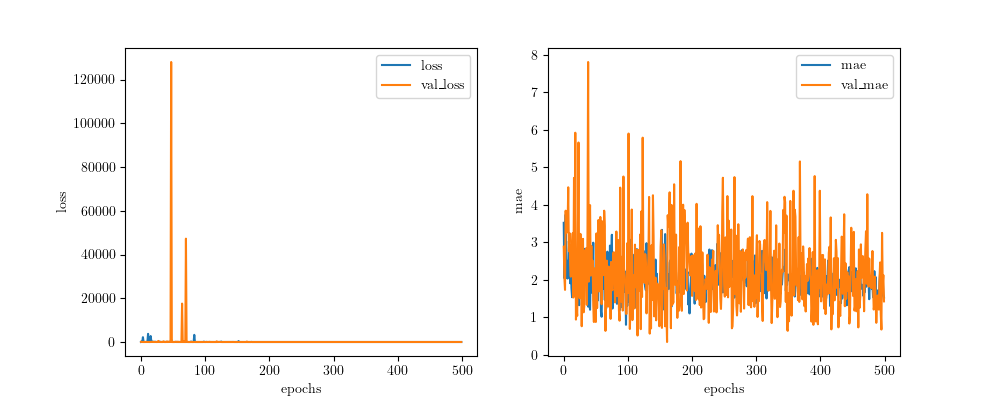

In [34]:
plot_history_info(BNN_history)

In [ ]:
# okay a bit noisy .. anyway ... let's do inference 

In [ ]:
# epistemic uncertainty 

In [ ]:
# predictive uncertainty (aleatoric and epistemic)